<a href="https://colab.research.google.com/github/AllMight2099/ml4sci-qcnn-eval/blob/master/Task_III_TFQ_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Convolutional Neural Network

In [ ]:
!pip install tensorflow==2.3.1 --quiet
!pip install tensorflow-quantum --quiet

     |████████████████████████████████| 320.4MB 55kB/s 
     |████████████████████████████████| 460kB 51.7MB/s 
     |████████████████████████████████| 20.1MB 161kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

### 1. **QCNN layers**

Define the layers that make up the model using the <a href="https://arxiv.org/abs/1810.03787" class="external">Cong and Lukin QCNN paper</a>. There are a few prerequisites:

* The one- and two-qubit parameterized unitary matrices from the <a href="https://arxiv.org/abs/quant-ph/0507171" class="external">Tucci paper</a>.
* A general parameterized two-qubit pooling operation.

### 2. **Quantum convolution**

As in the <a href="https://arxiv.org/abs/1810.03787" class="external">Cong and Lukin</a> paper, define the 1D quantum convolution as the application of a two-qubit parameterized unitary to every pair of adjacent qubits with a stride of one.

In [ ]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

In [ ]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

Display the (very horizontal) circuit:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


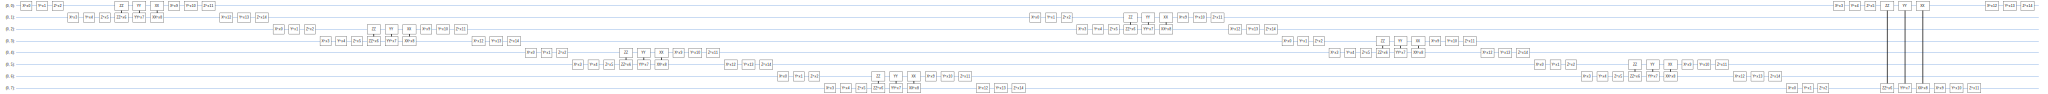

In [ ]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

### 3. **Quantum pooling**

A quantum pooling layer pools from $N$ qubits to $\frac{N}{2}$ qubits using the two-qubit pool defined above.

In [ ]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

Examine a pooling component circuit:

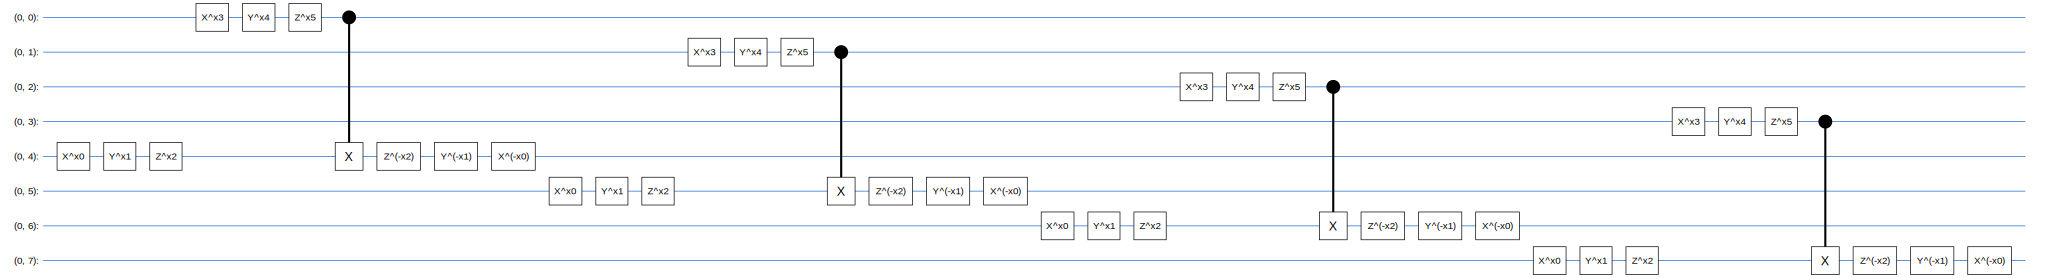

In [ ]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

### 4. **Data**
Loading data, downsizing it using sklearn's PCA and encoding it into Quantum datapoint:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = np.load('/content/drive/MyDrive/QCNN Dataset/electron-photon.npz')
x_train=data['x_train']
x_test=data['x_test.npy']
y_train=data['y_train']
y_test=data['y_test']
x_train.shape
x_test.shape

(100, 32, 32)

(100, 1024)


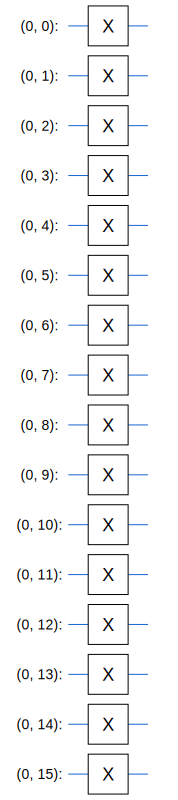

In [ ]:
from sklearn.decomposition import PCA
 
pca = PCA(16) # we need 16 principal components.
X_train=[]
X_test=[]

THRESHOLD = 0

for i in range(x_train.shape[0]):
  X_train.append(x_train[i].flatten())
  X_test.append(x_test[i].flatten())

X_train=np.array(X_train)
print(X_train.shape)
X_test=np.array(X_test)
X_train=np.array(X_train > THRESHOLD, dtype=np.float32)
X_test=np.array(X_test > THRESHOLD, dtype=np.float32)
X_train = pca.fit_transform(X_train)
X_test=pca.fit_transform(X_test)

def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = image
    qubits = cirq.GridQubit.rect(1, 16)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
      if value:
        circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in X_train]
x_test_circ = [convert_to_circuit(x) for x in X_test]

SVGCircuit(x_train_circ[0])

### 5. **Model definition**

Using the defined layers to construct a purely quantum CNN. Start with eight qubits, pool down to one, then measure $\langle \hat{Z} \rangle$.

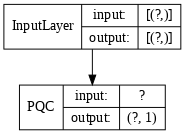

In [ ]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:84')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:8], qubits[8:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[8:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[8:12], qubits[12:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[12:], symbols[42:57])
    model_circuit += quantum_pool_circuit(qubits[12:14], qubits[14:],
                                          symbols[57:63])
    model_circuit += quantum_conv_circuit(qubits[14:], symbols[63:78])
    model_circuit += quantum_pool_circuit(qubits[14:15], qubits[15:],
                                          symbols[78:84])
    
    return model_circuit


# Create our qubits and readout operators in Cirq.
input_state_bits = cirq.GridQubit.rect(1, 16)
readout_operators = cirq.Z(input_state_bits[-1])

# Build a sequential model
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

quantum_model = tfq.layers.PQC(create_model_circuit(input_state_bits),
                               readout_operators)(inputs)

qcnn_model = tf.keras.Model(inputs=[inputs], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

### 6. **Train the model**

Train the model over the full batch:

In [ ]:
# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])
print(qcnn_model.summary())


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
pqc (PQC)                    (None, 1)                 84        
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = qcnn_model.fit(x=tfq.convert_to_tensor(x_train_circ),
                         y=y_train,
                         batch_size=16,
                         epochs=100,
                         verbose=1,
                         validation_data=(tfq.convert_to_tensor(x_test_circ), y_test))
qcnn_results = qcnn_model.evaluate(tfq.convert_to_tensor(x_test_circ), y_test)

Epoch 1/100
7/7 [==============================] - 17s 2s/step - loss: 0.5491 - custom_accuracy: 0.4196 - val_loss: 0.4363 - val_custom_accuracy: 0.5179
Epoch 2/100
7/7 [==============================] - 17s 2s/step - loss: 0.5233 - custom_accuracy: 0.5536 - val_loss: 0.4177 - val_custom_accuracy: 0.5179
Epoch 3/100
7/7 [==============================] - 17s 2s/step - loss: 0.4992 - custom_accuracy: 0.6071 - val_loss: 0.3973 - val_custom_accuracy: 0.5179
Epoch 4/100
7/7 [==============================] - 17s 2s/step - loss: 0.4731 - custom_accuracy: 0.5536 - val_loss: 0.3763 - val_custom_accuracy: 0.5179
Epoch 5/100
7/7 [==============================] - 17s 2s/step - loss: 0.4455 - custom_accuracy: 0.5804 - val_loss: 0.3544 - val_custom_accuracy: 0.5179
Epoch 6/100
7/7 [==============================] - 17s 2s/step - loss: 0.4151 - custom_accuracy: 0.5268 - val_loss: 0.3292 - val_custom_accuracy: 0.5179
Epoch 7/100
7/7 [==============================] - 17s 2s/step - loss: 0.3807 - cu

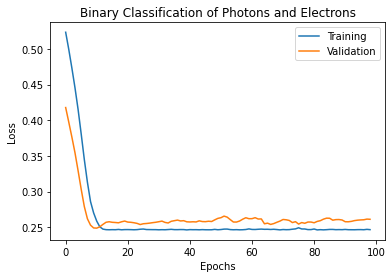

In [ ]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Binary Classification of Photons and Electrons')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

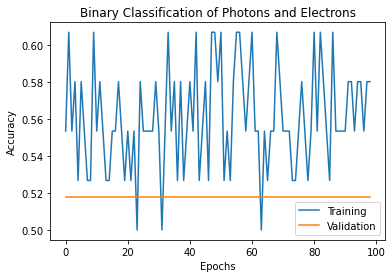

In [ ]:
plt.plot(history.history['custom_accuracy'][1:], label='Training')
plt.plot(history.history['val_custom_accuracy'][1:], label='Validation')
plt.title('Binary Classification of Photons and Electrons')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()